In [3]:
pip install numpy torch torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import os, sys
import numpy as np
import torch
from torchvision import models

# Asegúrate de que tu proyecto está en sys.path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from models.pytorch import PyTorchModel
from pca.pca_detector import find_kp_point  # tu versión actualizada
from attacks.carlini_wagner import CarliniWagnerL2Attack
from criteria import Misclassification
from distances import MeanSquaredDistance as MSE
from adversarial import Adversarial

# 1) Configuración global
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mean = np.array([0.485, 0.456, 0.406]); std = np.array([0.229, 0.224, 0.225])
min_val, max_val = float(((0-mean)/std).min()), float(((1-mean)/std).max())
bounds = (min_val, max_val)
num_classes = 2  # ajustar a tu tarea

# 2) Definición de modelos y checkpoints
model_defs = {
    "resnet18":        ("model_weights/resnet18_xray_best.pth",    models.resnet18),
    "resnet50":        ("model_weights/resnet50_best.pth",       models.resnet50),
    "densenet121":     ("model_weights/densenet121_best.pth",    models.densenet121),
    "efficientnet_b0": ("model_weights/efficientnet_b0_best.pth",models.efficientnet_b0),
    "vgg19":           ("model_weights/vgg19_best.pth",          models.vgg19),
}

# 3) Carga de features numpy previamente guardados
data_np = {}
for name in model_defs:
    data_np[name] = {
        "benign":      np.load(f"features/{name}_benign.npy"),
        "adversarial": np.load(f"features/{name}_adversarial.npy")
    }

# 4) Para cada modelo, calcula sus kp points
all_kp = {}

for name, (ckpt, constructor) in model_defs.items():
    print(f"\n=== Procesando modelo: {name} ===")

    # a) Instanciar y ajustar capa final antes de cargar pesos
    model = constructor(pretrained=False)
    # ajustar última capa según arquitectura
    if name.startswith("resnet"):
        in_f = model.fc.in_features
        model.fc = torch.nn.Linear(in_f, num_classes)
    elif name.startswith("densenet"):
        in_f = model.classifier.in_features
        model.classifier = torch.nn.Linear(in_f, num_classes)
    elif name.startswith("efficientnet"):
        in_f = model.classifier[1].in_features
        model.classifier[1] = torch.nn.Linear(in_f, num_classes)
    elif name.startswith("vgg"):
        in_f = model.classifier[-1].in_features
        model.classifier[-1] = torch.nn.Linear(in_f, num_classes)

    # b) Cargar pesos y mover a CUDA
    model.load_state_dict(torch.load(ckpt, map_location=device))
    model.to(device).eval()

    # c) Wrappear
    fmodel = PyTorchModel(
        model,
        bounds=bounds,
        num_classes=num_classes,
        channel_axis=1,
        device=device
    )

    # d) Calcular kp para benignas
    benign_images = data_np[name]["benign"]
    benign_kp = []
    print("Calculando puntos (k, p) para imágenes benignas...")
    for i, img in enumerate(benign_images, start=1):
        print(f" Procesando imagen benigna {i}/{len(benign_images)}")
        kp = find_kp_point(img, fmodel)
        if kp[0] is not None:
            benign_kp.append(kp)

    # e) Calcular kp para adversariales
    adv_images = data_np[name]["adversarial"]
    adv_kp = []
    print("Calculando puntos (k, p) para imágenes adversariales...")
    for i, img in enumerate(adv_images, start=1):
        print(f" Procesando imagen adversarial {i}/{len(adv_images)}")
        kp = find_kp_point(img, fmodel)
        if kp[0] is not None:
            adv_kp.append(kp)

    # f) Guardar en el diccionario
    all_kp[name] = {
        "benign_kp": benign_kp,
        "adv_kp":    adv_kp
    }



=== Procesando modelo: resnet18 ===
Calculando puntos (k, p) para imágenes benignas...
 Procesando imagen benigna 1/100
 Procesando imagen benigna 2/100
 Procesando imagen benigna 3/100
 Procesando imagen benigna 4/100
 Procesando imagen benigna 5/100
 Procesando imagen benigna 6/100
 Procesando imagen benigna 7/100
 Procesando imagen benigna 8/100
 Procesando imagen benigna 9/100
 Procesando imagen benigna 10/100
 Procesando imagen benigna 11/100
 Procesando imagen benigna 12/100
 Procesando imagen benigna 13/100
 Procesando imagen benigna 14/100
 Procesando imagen benigna 15/100
 Procesando imagen benigna 16/100
 Procesando imagen benigna 17/100
 Procesando imagen benigna 18/100
 Procesando imagen benigna 19/100
 Procesando imagen benigna 20/100
 Procesando imagen benigna 21/100
 Procesando imagen benigna 22/100
 Procesando imagen benigna 23/100
 Procesando imagen benigna 24/100
 Procesando imagen benigna 25/100
 Procesando imagen benigna 26/100
 Procesando imagen benigna 27/100
 Pr

In [8]:
# 1) Directorio de salida
output_dir = "kp_points"
os.makedirs(output_dir, exist_ok=True)

# 2) Recorre el diccionario all_kp generado antes
for name, kp_dict in all_kp.items():
    benign_kp = kp_dict["benign_kp"]
    adv_kp    = kp_dict["adv_kp"]

    # Convertir a arrays de forma (N,2)
    benign_arr = np.array(benign_kp) if benign_kp else np.empty((0,2))
    adv_arr    = np.array(adv_kp)    if adv_kp    else np.empty((0,2))

    # Rutas de archivo
    benign_path = os.path.join(output_dir, f"{name}_benign_kp.npy")
    adv_path    = os.path.join(output_dir, f"{name}_adv_kp.npy")

    # Guardar
    np.save(benign_path, benign_arr)
    np.save(adv_path,    adv_arr)

    print(f"Guardado {benign_arr.shape[0]} benign kp en {benign_path}")
    print(f"Guardado {adv_arr.shape[0]} adversarial kp en {adv_path}")


Guardado 92 benign kp en kp_points\resnet18_benign_kp.npy
Guardado 78 adversarial kp en kp_points\resnet18_adv_kp.npy
Guardado 90 benign kp en kp_points\resnet50_benign_kp.npy
Guardado 92 adversarial kp en kp_points\resnet50_adv_kp.npy
Guardado 93 benign kp en kp_points\densenet121_benign_kp.npy
Guardado 100 adversarial kp en kp_points\densenet121_adv_kp.npy
Guardado 88 benign kp en kp_points\efficientnet_b0_benign_kp.npy
Guardado 97 adversarial kp en kp_points\efficientnet_b0_adv_kp.npy
Guardado 88 benign kp en kp_points\vgg19_benign_kp.npy
Guardado 72 adversarial kp en kp_points\vgg19_adv_kp.npy


In [9]:
pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ----- --------------------------------- 41.0/294.9 kB 653.6 kB/s eta 0:00:01
   ------------------------------ --------- 225.3/294.9 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Exception ignored in: <function tqdm.__del__ at 0x0000020B15E2E520>
Traceback (most recent call last):
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


resnet18 -> mejor umbral k=32, acc=59.41%


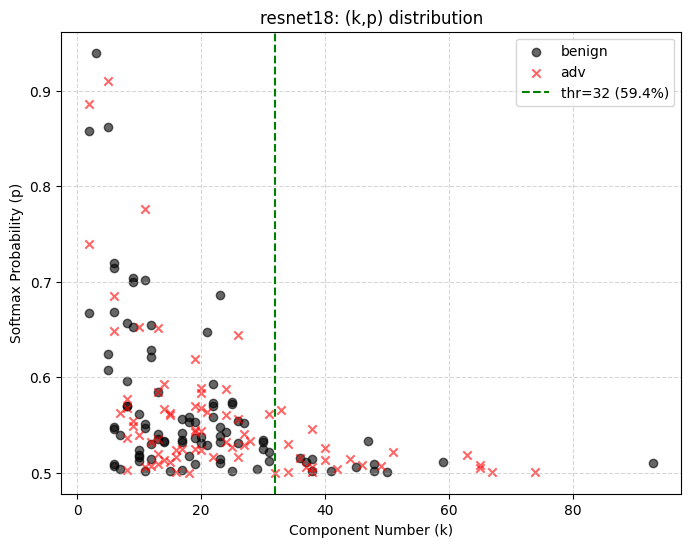

resnet50 -> mejor umbral k=47, acc=97.80%


densenet121 -> mejor umbral k=42, acc=100.00%


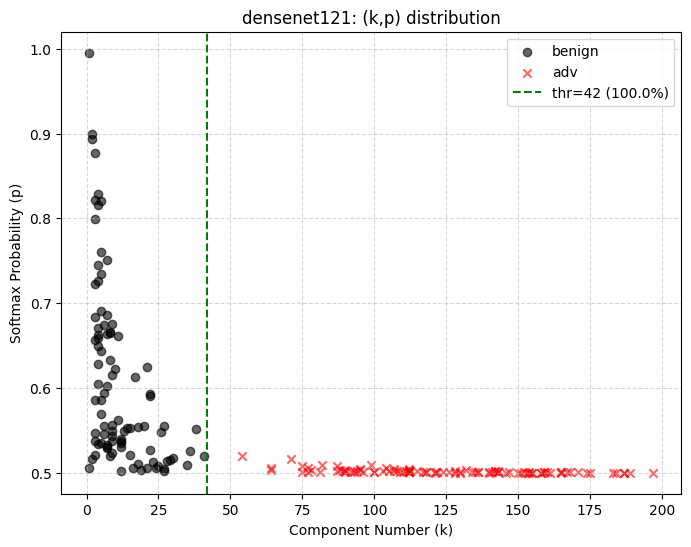

efficientnet_b0 -> mejor umbral k=78, acc=98.92%


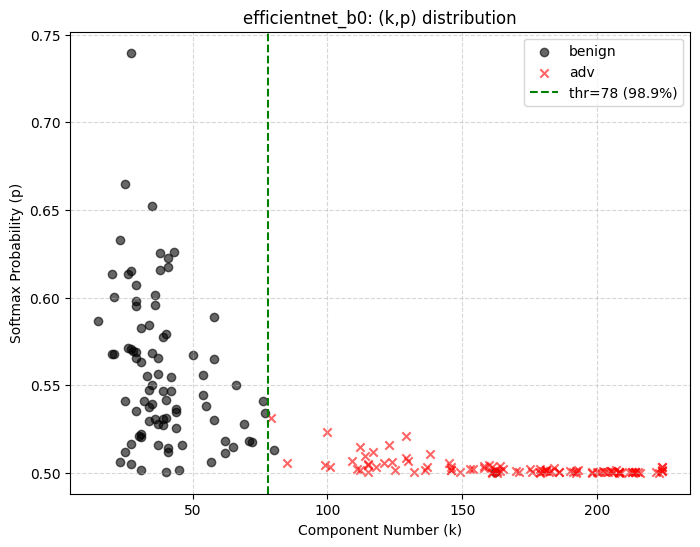

vgg19 -> mejor umbral k=93, acc=95.62%


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.linear_model import LogisticRegression
# Carga puntos kp guardados
kp_points = {}
for name in model_defs:
    ben = np.load(os.path.join("kp_points", f"{name}_benign_kp.npy"))
    adv = np.load(os.path.join("kp_points", f"{name}_adv_kp.npy"))
    kp_points[name] = {"benign": ben, "adv": adv}

# Celda A: plot y umbral
for name, kp in kp_points.items():
    benign = kp["benign"]
    adv    = kp["adv"]
    bk, bp = benign[:,0], benign[:,1]
    ak, ap = adv[:,0],    adv[:,1]

    # scatter
    plt.figure(figsize=(8,6))
    plt.scatter(bk, bp, c='black', alpha=0.6, label='benign')
    plt.scatter(ak, ap, c='red',   alpha=0.6, label='adv', marker='x')
    plt.title(f"{name}: (k,p) distribution")
    plt.xlabel("Component Number (k)")
    plt.ylabel("Softmax Probability (p)")
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)

    # umbral en k
    all_k = np.concatenate([bk, ak])
    y_true = np.array([0]*len(bk) + [1]*len(ak))
    best_thr, best_acc = 0, 0
    for thr in range(1, int(all_k.max())+1):
        y_pred = (all_k >= thr).astype(int)
        acc = (y_pred == y_true).mean()
        if acc > best_acc:
            best_acc, best_thr = acc, thr

    print(f"{name} -> mejor umbral k={best_thr}, acc={best_acc*100:.2f}%")
    plt.axvline(best_thr, color='green', linestyle='--',
                label=f"thr={best_thr} ({best_acc*100:.1f}%)")
    plt.legend(); plt.show()


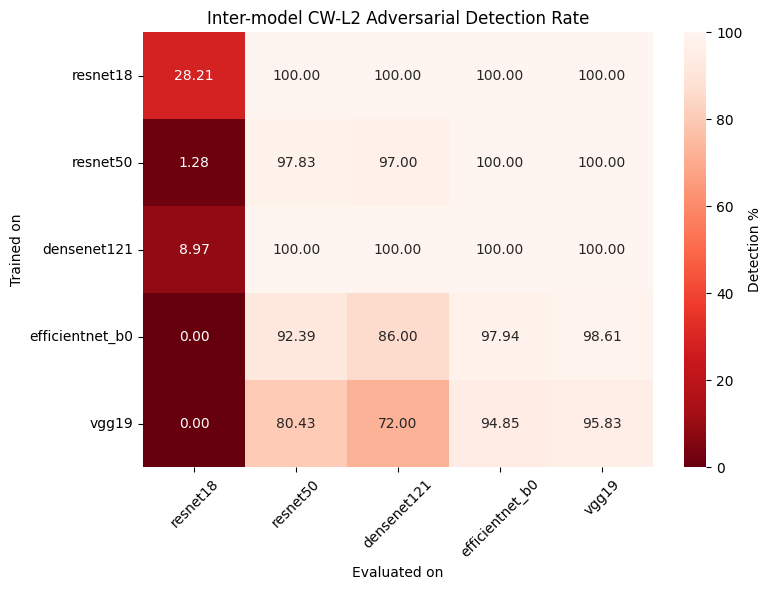

In [26]:
# 1) Entrenar detectores por modelo
kp_points = {}
for name in model_defs.keys():
    ben = np.load(os.path.join("kp_points", f"{name}_benign_kp.npy"))
    adv = np.load(os.path.join("kp_points", f"{name}_adv_kp.npy"))
    kp_points[name] = {"benign": ben, "adv": adv}
    
model_names = list(model_defs.keys())
detectors = {}
names = list(model_defs.keys())
for m in names:
    X_pos = kp_points[m]['adv']
    X_neg = kp_points[m]['benign']
    X = np.vstack([X_pos, X_neg])
    y = np.hstack([np.ones(len(X_pos)), np.zeros(len(X_neg))])
    detectors[m] = LogisticRegression().fit(X, y)

# 2) Calcular matriz de tasas de detección
d = len(names)
rates = np.zeros((d, d))
for i, m_tr in enumerate(names):
    clf = detectors[m_tr]
    for j, m_ev in enumerate(names):
        X_test = kp_points[m_ev]['adv']
        rates[i, j] = (clf.predict(X_test) == 1).mean() * 100

# 3) Dibujar heatmap con la misma escala de colores (0–100)
plt.figure(figsize=(8, 6))
sns.heatmap(
    rates,
    xticklabels=names,
    yticklabels=names,
    annot=True,
    fmt=".2f",
    cmap="Reds_r",
    vmin=0,
    vmax=100,
    cbar_kws={"label": "Detection %"}
)
plt.xlabel("Evaluated on")
plt.ylabel("Trained on")
plt.title("Inter-model CW-L2 Adversarial Detection Rate")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


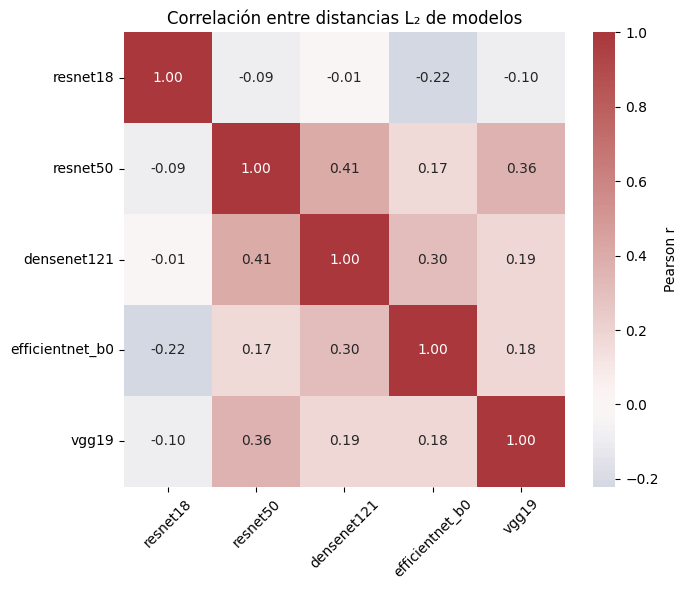

In [42]:
min_n = min(len(d) for d in distances.values())
corr_matrix = np.zeros((len(model_names), len(model_names)))
for i, ni in enumerate(model_names):
    for j, nj in enumerate(model_names):
        d1 = distances[ni][:min_n]
        d2 = distances[nj][:min_n]
        corr_matrix[i, j] = np.corrcoef(d1, d2)[0, 1]

plt.figure(figsize=(7,6))
sns.heatmap(
    corr_matrix,
    xticklabels=model_names,
    yticklabels=model_names,
    annot=True, fmt=".2f",
    cmap="vlag", center=0,
    cbar_kws={"label":"Pearson r"}
)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Correlación entre distancias L₂ de modelos")
plt.tight_layout()
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24592\1101372511.py:25: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(ak, ap, c='red', marker='o', facecolors='none', alpha=0.8, label='Adversarial')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24592\1101372511.py:28: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(ak, ap, c='red', marker='o', facecolors='none', alpha=0.8)


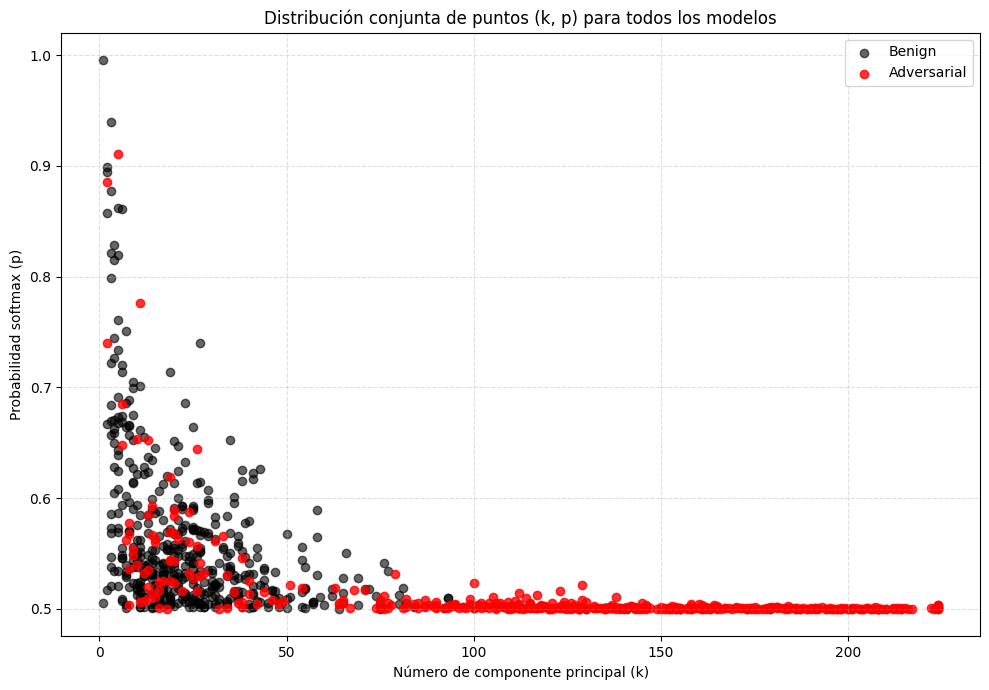

In [15]:
# Carga puntos kp guardados
kp_points = {}
for name in model_defs:
    ben = np.load(os.path.join("kp_points", f"{name}_benign_kp.npy"))
    adv = np.load(os.path.join("kp_points", f"{name}_adv_kp.npy"))
    kp_points[name] = {"benign": ben, "adv": adv}

plt.figure(figsize=(10,7))

# Graficar todos los benignos en negro, una sola vez la etiqueta
first_b = True
for name, kp in kp_points.items():
    bk, bp = kp['benign'][:,0], kp['benign'][:,1]
    if first_b:
        plt.scatter(bk, bp, c='black', marker='o', alpha=0.6, label='Benign')
        first_b = False
    else:
        plt.scatter(bk, bp, c='black', marker='o', alpha=0.6)

# Graficar todos los adversariales en rojo, una sola vez la etiqueta
first_a = True
for name, kp in kp_points.items():
    ak, ap = kp['adv'][:,0], kp['adv'][:,1]
    if first_a:
        plt.scatter(ak, ap, c='red', marker='o', facecolors='none', alpha=0.8, label='Adversarial')
        first_a = False
    else:
        plt.scatter(ak, ap, c='red', marker='o', facecolors='none', alpha=0.8)

plt.title('Distribución conjunta de puntos (k, p) para todos los modelos')
plt.xlabel('Número de componente principal (k)')
plt.ylabel('Probabilidad softmax (p)')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [19]:
# Obtener la lista de nombres, excluyendo 'resnet18'
model_names = [name for name in model_defs.keys() if name != 'resnet18']

# Cargar los puntos kp de esos modelos
kp_points = {}
for name in model_names:
    ben = np.load(os.path.join("kp_points", f"{name}_benign_kp.npy"))
    adv = np.load(os.path.join("kp_points", f"{name}_adv_kp.npy"))
    kp_points[name] = {"benign": ben, "adv": adv}

plt.figure(figsize=(10,7))

# Dibujar benignos (negro), una sola etiqueta
plotted_b = False
for kp in kp_points.values():
    bk, bp = kp['benign'][:,0], kp['benign'][:,1]
    if not plotted_b:
        plt.scatter(bk, bp, c='black', marker='o', alpha=0.6, label='Benign')
        plotted_b = True
    else:
        plt.scatter(bk, bp, c='black', marker='o', alpha=0.6)

# Dibujar adversariales (rojo), una sola etiqueta
plotted_a = False
for kp in kp_points.values():
    ak, ap = kp['adv'][:,0], kp['adv'][:,1]
    if not plotted_a:
        plt.scatter(ak, ap, c='red', marker='o', facecolors='none', alpha=0.8, label='Adversarial')
        plotted_a = True
    else:
        plt.scatter(ak, ap, c='red', marker='o', facecolors='none', alpha=0.8)

plt.title('Distribución conjunta de puntos (k, p) excluyendo ResNet18')
plt.xlabel('Número de componente principal (k)')
plt.ylabel('Probabilidad softmax (p)')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24592\1124093494.py:28: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(ak, ap, c='red', marker='o', facecolors='none', alpha=0.8, label='Adversarial')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24592\1124093494.py:31: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(ak, ap, c='red', marker='o', facecolors='none', alpha=0.8)


In [35]:
from itertools import cycle

# Cargar puntos kp guardados
kp_points = {}
for name in model_defs:
    ben = np.load(os.path.join("kp_points", f"{name}_benign_kp.npy"))
    adv = np.load(os.path.join("kp_points", f"{name}_adv_kp.npy"))
    kp_points[name] = {"benign": ben, "adv": adv}

# Colores para cada modelo
colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot benignos en ax1 (círculos)
for name in kp_points:
    c = next(colors)
    bk, bp = kp_points[name]['benign'][:,0], kp_points[name]['benign'][:,1]
    ax1.scatter(bk, bp, c=c, marker='o', alpha=0.7, label=name)
ax1.set_title('Benign samples for different architectures')
ax1.set_xlabel('Component Number (k)')
ax1.set_ylabel('Softmax Probability (p)')
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.legend(loc='upper right', fontsize='small')

# Reiniciar ciclo de colores para que los modelos coincidan
colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Plot adversariales en ax2 
for name in kp_points:
    c = next(colors)
    ak, ap = kp_points[name]['adv'][:,0], kp_points[name]['adv'][:,1]
    ax2.scatter(ak, ap, c=c, marker='o', alpha=0.7, label=name)
ax2.set_title('Carlini Wagner adversarial attacks on different architectures')
ax2.set_xlabel('Component Number (k)')
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.legend(loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()


In [36]:
# 1) Carga todas las distancias desde disco
distances = {}
for name in model_defs:
    path = os.path.join("kp_points", f"{name}_distances.npy")
    # si guardaste en features/, cambia el directorio
    if not os.path.exists(path):
        path = os.path.join("features", f"{name}_distances.npy")
    distances[name] = np.load(path)

# 2) Boxplot (o violinplot) de distancias
plt.figure(figsize=(8,6))
sns.boxplot(
    data=[distances[name] for name in model_defs],
    palette="Set2"
)
plt.xticks(range(len(model_defs)), list(model_defs.keys()), rotation=45)
plt.ylabel("Distancia L₂ (MSE)")
plt.title("Comparación de distancias L₂ de ataques adversariales por modelo")
plt.tight_layout()
plt.show()

In [41]:
# 1) Cargar distancias L2 para cada modelo
model_names = list(model_defs.keys())
distances = {}
for name in model_names:
    # Ajusta la ruta si lo guardaste en otro directorio
    path = os.path.join("features", f"{name}_distances.npy")
    distances[name] = np.load(path)

# 2) Violin plot de distribuciones de distancia L2
plt.figure(figsize=(8,6))
sns.violinplot(
    data=[distances[name] for name in model_names],
    palette="Set2"
)
plt.xticks(ticks=range(len(model_names)), labels=model_names, rotation=45)
plt.ylabel("Distancia L₂")
plt.title("Distribución de distancias L₂ de ataques adversariales por modelo")
plt.tight_layout()
plt.show()

In [39]:
plt.figure(figsize=(8,6))

for name in model_defs:
    # 1) Cargar kp y distancias
    kp = np.load(f"kp_points/{name}_adv_kp.npy")          # forma (N_kp, 2)
    d  = np.load(f"features/{name}_distances.npy")        # forma (N_d,)
    
    # 2) Igualar longitudes
    n = min(len(kp), len(d))
    k_vals = kp[:n, 0]
    d_vals = d[:n]
    
    # 3) Plot
    plt.scatter(k_vals, d_vals, alpha=0.6, label=name)

# 4) Ajustes finales
plt.yscale("log")
plt.xlabel("Componente Principal Mínimo (k)")
plt.ylabel("Distancia L₂")
plt.title("k vs. L₂ para ejemplos adversariales")
plt.legend(loc="upper right", fontsize="small")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



=== Modelo: resnet18 ===


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


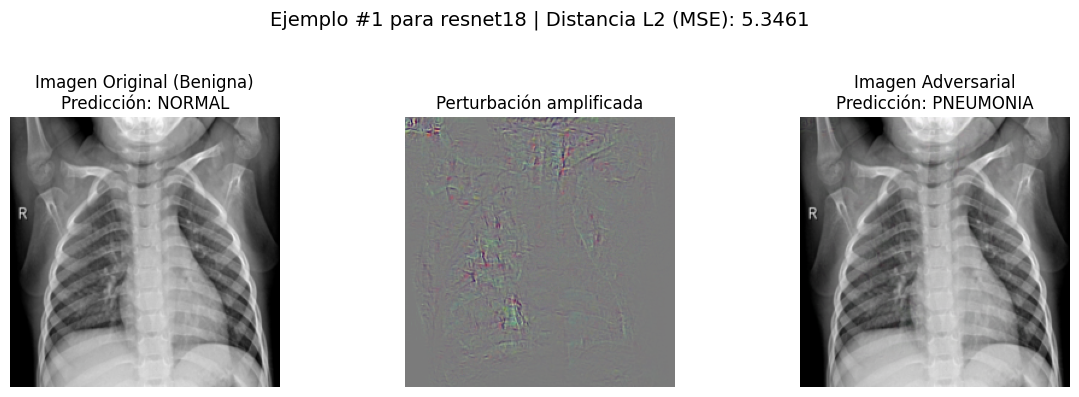


=== Modelo: resnet50 ===



=== Modelo: densenet121 ===


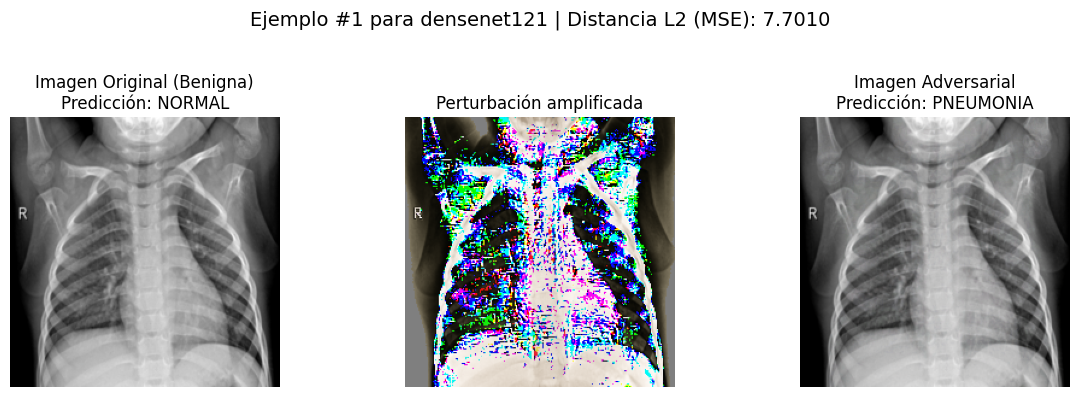

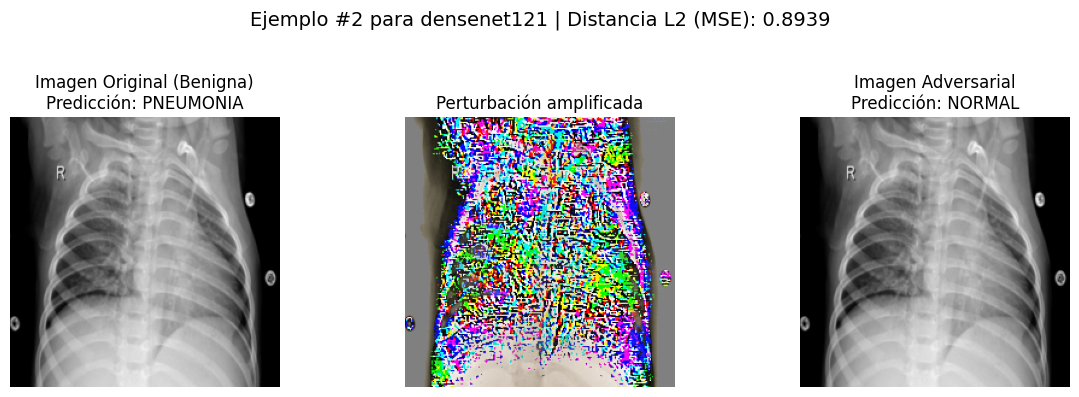


=== Modelo: efficientnet_b0 ===


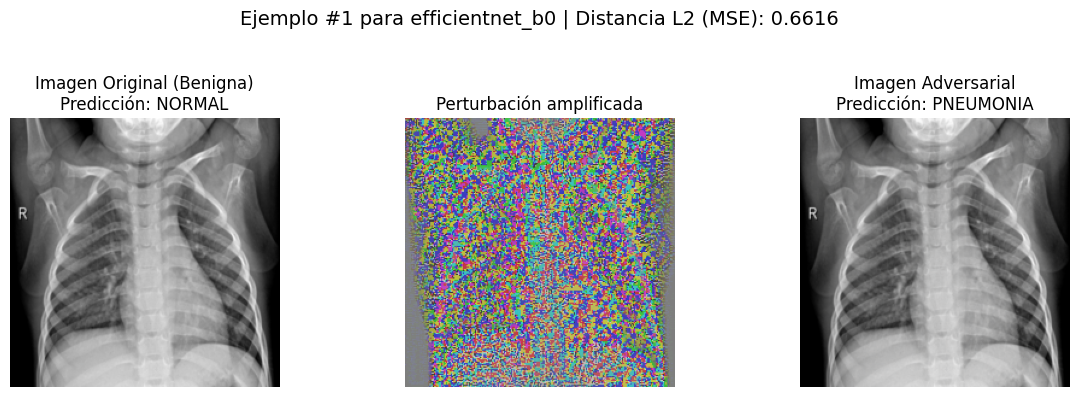

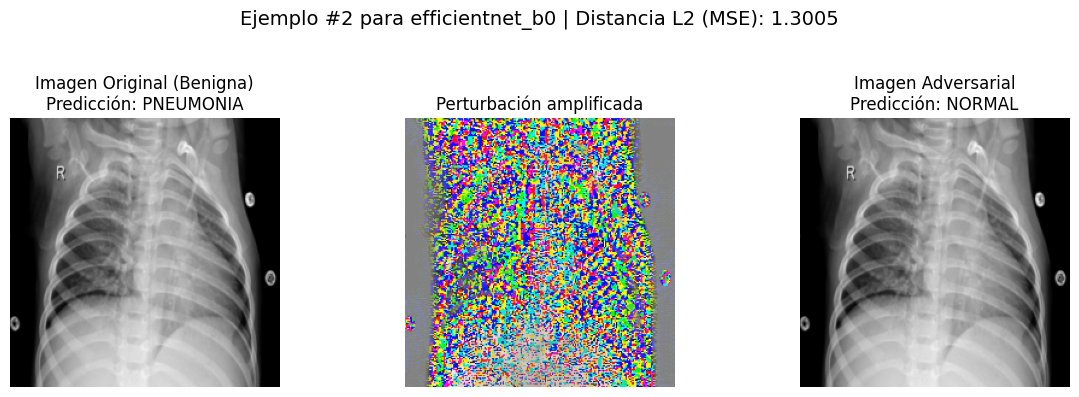


=== Modelo: vgg19 ===


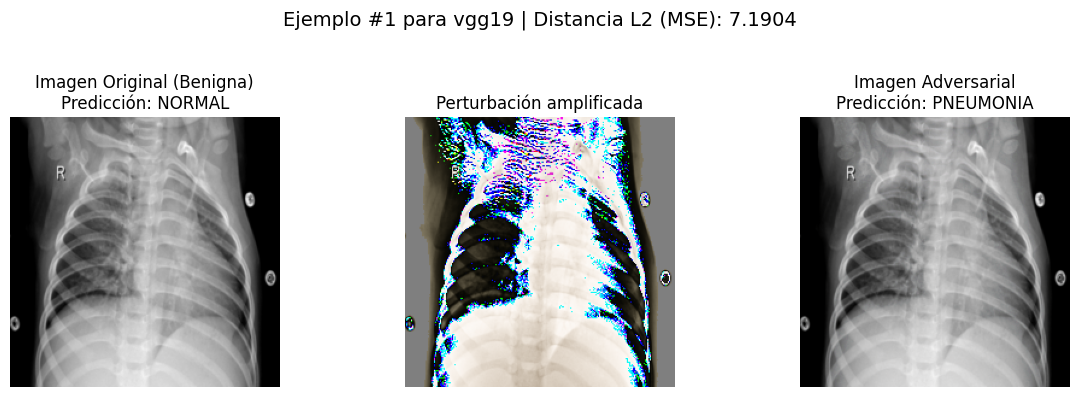

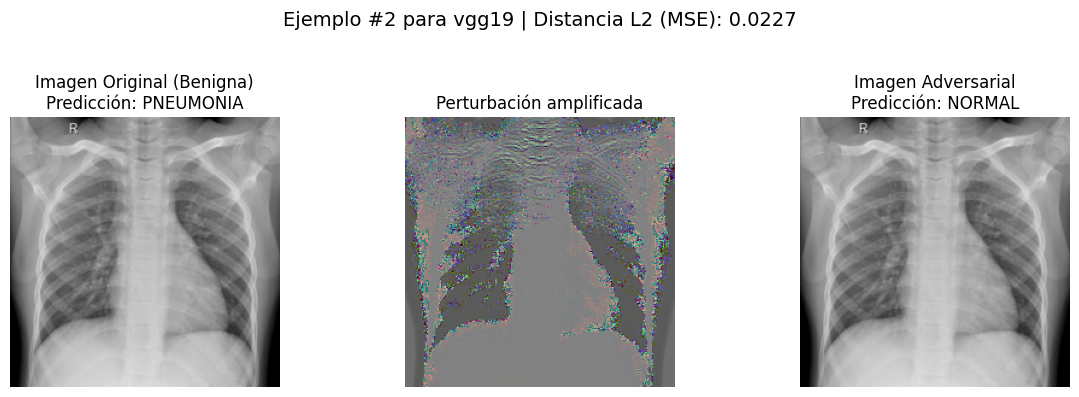

In [33]:
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
class_names = ['NORMAL', 'PNEUMONIA']

def plot_example(model, b_np, a_np, d_l2, name, idx):
    # des-normalizar
    b_vis = np.clip(b_np * std + mean, 0, 1)
    a_vis = np.clip(a_np * std + mean, 0, 1)
    # perturbación amplificada
    delta = a_vis - b_vis
    delta_vis = (delta - delta.min()) / (delta.max() - delta.min())
    # predicciones
    with torch.no_grad():
        tb = torch.from_numpy(b_np.transpose(2,0,1)).unsqueeze(0).to(device)
        ta = torch.from_numpy(a_np.transpose(2,0,1)).unsqueeze(0).to(device)
        pb = model(tb).argmax(dim=1).item()
        pa = model(ta).argmax(dim=1).item()
    # ploteo
    fig, axs = plt.subplots(1, 3, figsize=(12,4))
    axs[0].imshow(b_vis)
    axs[0].set_title(f"Imagen Original (Benigna)\nPredicción: {class_names[pb]}")
    axs[0].axis('off')
    axs[1].imshow(delta_vis)
    axs[1].set_title("Perturbación amplificada")
    axs[1].axis('off')
    axs[2].imshow(a_vis)
    axs[2].set_title(f"Imagen Adversarial\nPredicción: {class_names[pa]}")
    axs[2].axis('off')
    plt.suptitle(f"Ejemplo #{idx} para {name} | Distancia L2 (MSE): {d_l2:.4f}", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.9])
    plt.show()

for name, (ckpt, constructor) in model_defs.items():
    print(f"\n=== Modelo: {name} ===")
    # cargar y ajustar modelo
    model = constructor(pretrained=False)
    nc = len(class_names)
    if name.startswith("resnet"):
        model.fc = torch.nn.Linear(model.fc.in_features, nc)
    elif name.startswith("densenet"):
        model.classifier = torch.nn.Linear(model.classifier.in_features, nc)
    elif name.startswith("efficientnet"):
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, nc)
    elif name.startswith("vgg"):
        model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, nc)
    model.load_state_dict(torch.load(ckpt, map_location=device))
    model.to(device).eval()

    # cargar datos
    benign    = data_np[name]['benign']
    adv       = data_np[name]['adversarial']
    # si tienes distancias guardadas usa np.load, sino calcula
    distances = [np.linalg.norm(a - b) for b,a in zip(benign, adv)]

    # encontrar ejemplo Normal y Pneumonia
    idxs = {'NORMAL': None, 'PNEUMONIA': None}
    for i, b_np in enumerate(benign):
        t = torch.from_numpy(b_np.transpose(2,0,1)).unsqueeze(0).to(device)
        pred = model(t).argmax(dim=1).item()
        cls = class_names[pred]
        if cls in idxs and idxs[cls] is None:
            idxs[cls] = i
        if idxs['NORMAL'] is not None and idxs['PNEUMONIA'] is not None:
            break

    # plotear ambos ejemplos
    if idxs['NORMAL'] is not None:
        plot_example(model, benign[idxs['NORMAL']], adv[idxs['NORMAL']],
                     distances[idxs['NORMAL']], name, idx=1)
    else:
        print("No se encontró ejemplo NORMAL.")

    if idxs['PNEUMONIA'] is not None:
        plot_example(model, benign[idxs['PNEUMONIA']], adv[idxs['PNEUMONIA']],
                     distances[idxs['PNEUMONIA']], name, idx=2)
    else:
        print("No se encontró ejemplo PNEUMONIA.")

In [55]:
from pca.pca_detector import get_row_vectors, compute_principal_components, project_and_reconstruct
MEAN_NORM, STD_NORM = 0.1307, 0.3081
def plot_pca_reconstruction(image_np, k_values, nrows=3, ncols=3, cmap='gray'):
    """
    Reconstruye y plotea la imagen `image_np` usando PCA por filas.

    Args:
        image_np (np.ndarray): imagen HxWxC normalizada.
        model_name (str): nombre de la arquitectura (para título).
        k_values (list[int]): lista de k componentes a mostrar.
        nrows, ncols (int): disposición de subplots.
        cmap (str): colormap para plt.imshow.
    """
    total = nrows * ncols
    assert len(k_values) + 1 <= total, "Aumenta nrows*ncols o reduce k_values"

    # 1. PCA
    row_vecs = get_row_vectors(image_np)
    mean_vec, pcs = compute_principal_components(row_vecs)

    # 2. Crear figura
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    plt.suptitle(f"Reconstrucción PCA (rowPCA) para un ejemplo del dataset", fontsize=16)
    ax_list = axes.ravel()

    # 3. Original
    orig_vis = np.clip(image_np * STD_NORM + MEAN_NORM, 0, 1)
    ax_list[0].imshow(orig_vis.squeeze(), cmap=cmap)
    ax_list[0].set_title("Original")
    ax_list[0].axis('off')

    # 4. Reconstrucciones
    for idx, k in enumerate(k_values, start=1):
        recon = project_and_reconstruct(row_vecs, k, mean_vec, pcs)
        recon_img = recon.reshape(image_np.shape)
        recon_vis = np.clip(recon_img * STD_NORM + MEAN_NORM, 0, 1)
        ax_list[idx].imshow(recon_vis.squeeze(), cmap=cmap)
        ax_list[idx].set_title(f"k={k}")
        ax_list[idx].axis('off')

    # 5. Ocultar sobrantes
    for j in range(len(k_values) + 1, total):
        ax_list[j].axis('off')

    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

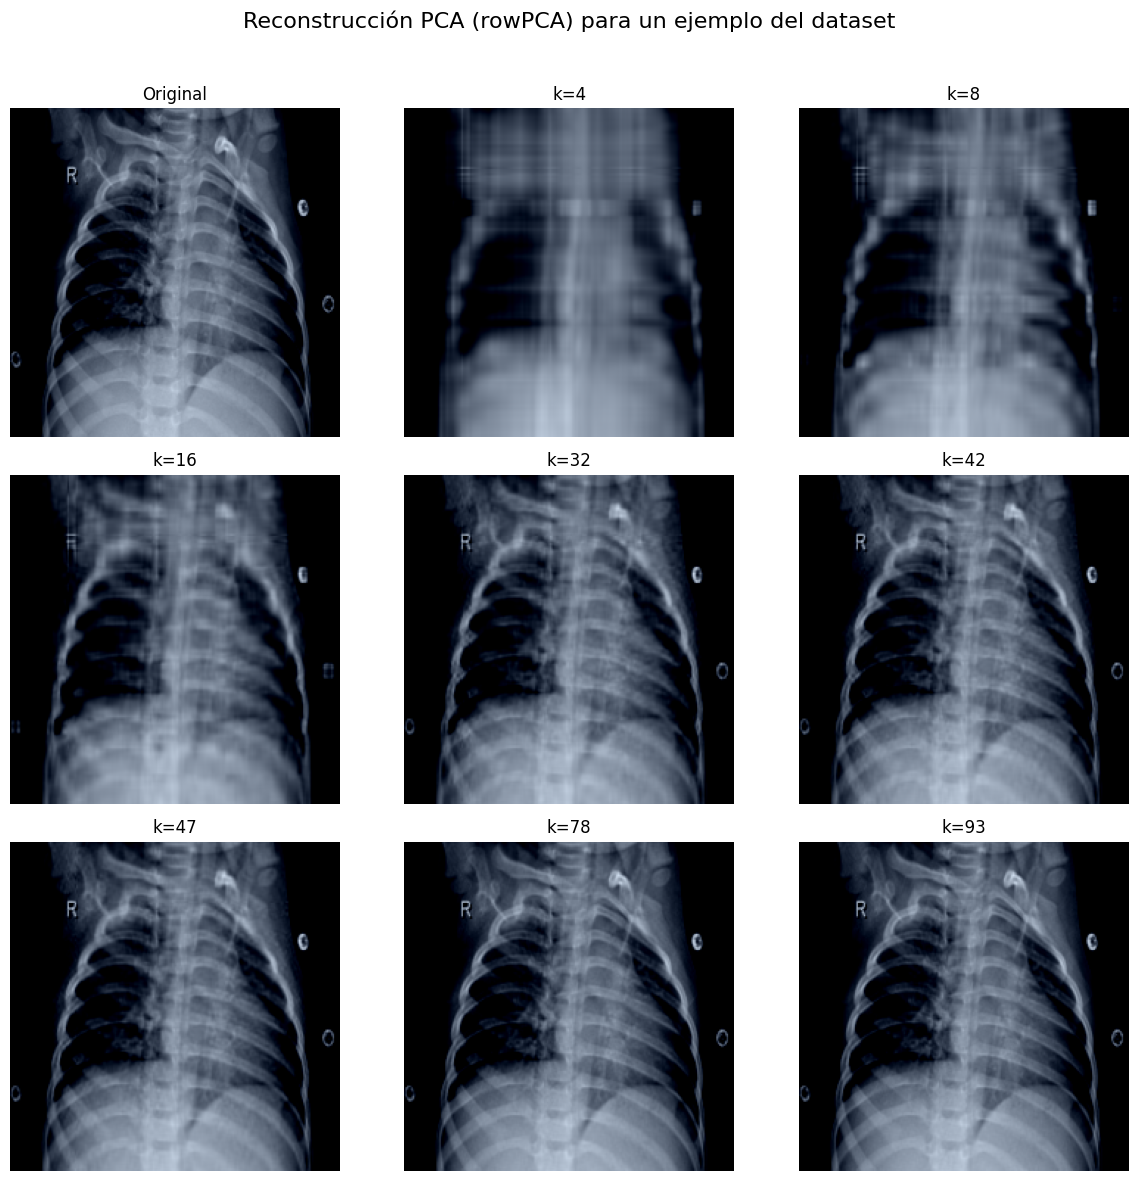

In [59]:
from pca.pca_detector import get_row_vectors, compute_principal_components, project_and_reconstruct
import random

# Construye una lista única con todas las imágenes benignas del dataset
all_benign = [img for model_dict in data_np.values() for img in model_dict["benign"]]
image_np = random.choice(all_benign)

# Modelo en curso: ResNet18
image_np = data_np['resnet18']["benign"][0]  # forma HxWxC normalizada
k_vals = [4, 8, 16, 32, 42, 47, 78, 93]

plot_pca_reconstruction(image_np, k_vals)


In [65]:
import pandas as pd

models = list(model_defs.keys())

records = []
for name in models:
    # cargar KP points y distancias
    kb = np.load(os.path.join("kp_points", f"{name}_benign_kp.npy"))[:,0]
    ka = np.load(os.path.join("kp_points", f"{name}_adv_kp.npy"))[:,0]
    d  = np.load(os.path.join("features", f"{name}_distances.npy"))
    
    # k95 como percentil 95 de la distribución de k
    k95_ben = np.percentile(kb, 95)
    k95_adv = np.percentile(ka, 95)
    delta   = k95_adv - k95_ben
    
    # estadísticas de L₂
    l2_med = np.median(d)
    l2_q3  = np.percentile(d, 75)
    
    records.append({
        "Modelo": name,
        "k95_ben": k95_ben,
        "k95_adv": k95_adv,
        "Δk95": delta,
        "L2_mediana": l2_med,
        "L2_q3": l2_q3
    })

df_benchmark = pd.DataFrame(records).set_index("Modelo")

In [78]:
df_display = df_benchmark.copy()
df_display["k95_ben"]    = df_display["k95_ben"].round(2)
df_display["k95_adv"]    = df_display["k95_adv"].round(2)
df_display["Δk95"]       = df_display["Δk95"].round(2)
df_display[["L2_mediana","L2_q3"]] = df_display[["L2_mediana","L2_q3"]].applymap(lambda x: f"{x:.1e}")
df_display

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24592\2930727044.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_display[["L2_mediana","L2_q3"]] = df_display[["L2_mediana","L2_q3"]].applymap(lambda x: f"{x:.1e}")


k95_ben  k95_adv    Δk95 L2_mediana    L2_q3
Modelo                                                       
resnet18           47.45    63.30   15.85    6.5e-06  1.7e-05
resnet50           44.20   196.90  152.70    4.2e-06  1.5e-05
densenet121        29.40   183.05  153.65    4.5e-06  1.6e-05
efficientnet_b0    71.65   223.20  151.55    8.8e-08  2.5e-07
vgg19             109.30   208.35   99.05    3.1e-06  1.7e-05

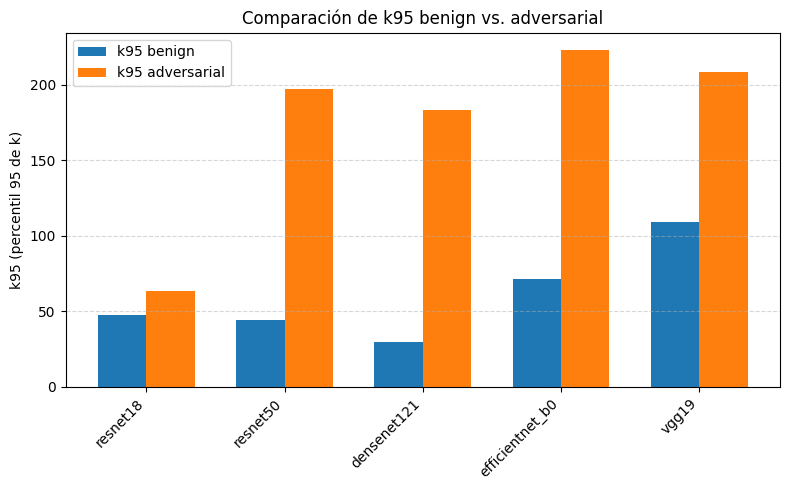

In [68]:
labels = df_benchmark.index.tolist()
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x - width/2, df_benchmark["k95_ben"],  width, label="k95 benign")
ax.bar(x + width/2, df_benchmark["k95_adv"],  width, label="k95 adversarial")

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylabel("k95 (percentil 95 de k)")
ax.set_title("Comparación de k95 benign vs. adversarial")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

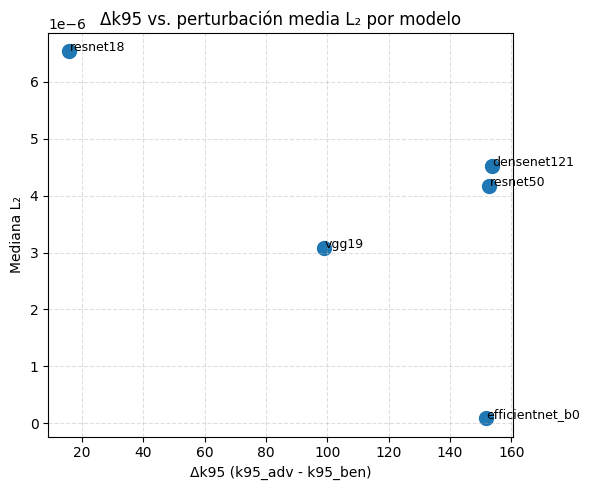

In [69]:
plt.figure(figsize=(6,5))
plt.scatter(df_benchmark["Δk95"], df_benchmark["L2_mediana"], s=100)

for name, row in df_benchmark.iterrows():
    plt.text(row["Δk95"]+0.2, row["L2_mediana"], name, fontsize=9)

plt.xlabel("Δk95 (k95_adv - k95_ben)")
plt.ylabel("Mediana L₂")
plt.title("Δk95 vs. perturbación media L₂ por modelo")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

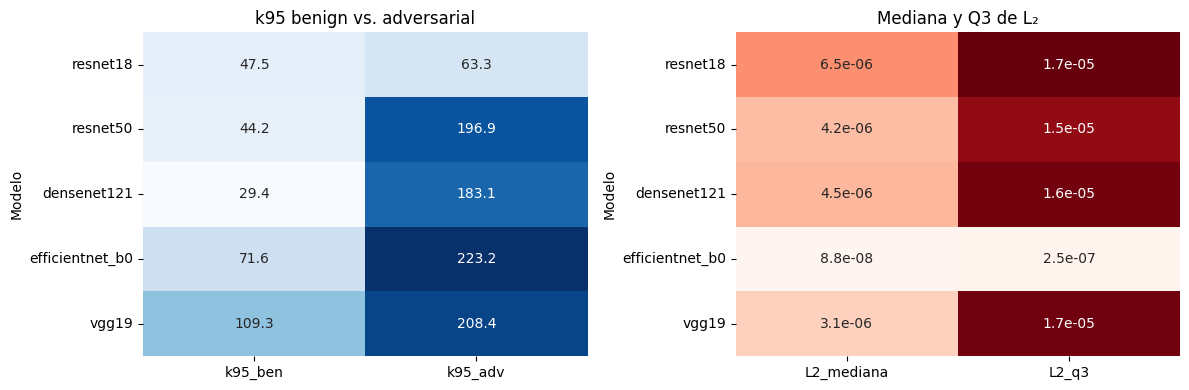

In [73]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.heatmap(df_benchmark[["k95_ben","k95_adv"]], annot=True, fmt=".1f",
            cmap="Blues", ax=ax[0], cbar=False)
ax[0].set_title("k95 benign vs. adversarial")

sns.heatmap(df_benchmark[["L2_mediana","L2_q3"]].astype(float), annot=True, fmt=".1e",
            cmap="Reds", ax=ax[1], cbar=False)
ax[1].set_title("Mediana y Q3 de L₂")

plt.tight_layout()
plt.show()

In [80]:
print("Fin.")

Fin.
